In [1]:
# https://www.rapidtables.com/web/color/RGB_Color.html
# https://github.com/codebrainz/color-names/blob/master/output/colors.csv

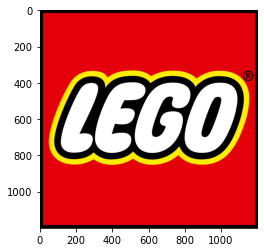

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt

# img = cv2.imread("../img/eardrops.jpg")
#img = cv2.imread("../img/flowers.jpg")
img = cv2.imread("../img/lego.png")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [39]:

# K Means clustering

# Convert to float32 array of N x 3, where each row is a pixel (R, G, B)
pixels = np.float32(img.reshape(-1, 3))

K = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, K, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)

average = img.mean(axis=0).mean(axis=0)
dominant = palette[np.argmax(counts)]


In [4]:
print(average)
print()
print(dominant)
print()
print(counts)
print()
print(palette)

[103.395616    39.74533067  63.19685333]

[45.9955   30.891354 26.36668 ]

[245220  90404 414376]

[[172.62994   11.777694 100.17733 ]
 [178.70474  156.19038  131.70049 ]
 [ 45.9955    30.891354  26.36668 ]]


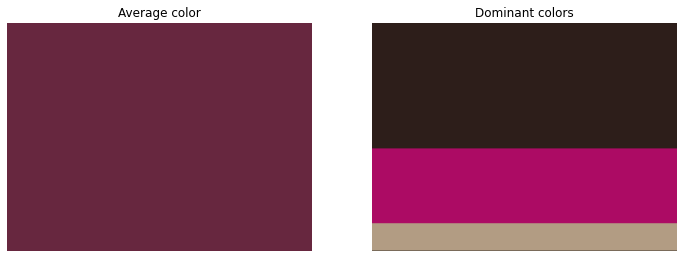

In [5]:
avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img.shape[0]*freqs)

dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
ax1.imshow(dom_patch)
ax1.set_title('Dominant colors')
ax1.axis('off')
plt.show(fig)

In [6]:
# Extract top 3 colors
count_to_color = {}
for i in range(len(counts)):
    count_to_color[counts[i]] = palette[i]
# print(count_to_color)

colors_sorted = []
for key in sorted(count_to_color, reverse=True):
    colors_sorted.append(np.array(count_to_color[key]))
    print("%s: %s" % (key, count_to_color[key]))
print()
print(colors_sorted)

414376: [45.9955   30.891354 26.36668 ]
245220: [172.62994   11.777694 100.17733 ]
90404: [178.70474 156.19038 131.70049]

[array([45.9955  , 30.891354, 26.36668 ], dtype=float32), array([172.62994 ,  11.777694, 100.17733 ], dtype=float32), array([178.70474, 156.19038, 131.70049], dtype=float32)]


In [7]:
# colors = pd.read_csv("colors_small_with_hsv.csv")
colors = pd.read_csv("colors_medium_with_hsv.csv")
# colors = pd.read_csv("colors_large_with_hsv.csv")

In [8]:
color_names = []

for color in colors_sorted:
    min_dist = np.inf
    color_name = ""
    for _, row in colors.iterrows():
        rgb_array = np.array([row["R"], row["G"], row["B"]])

        dist = np.linalg.norm(color - rgb_array)
        if dist < min_dist:
            min_dist = dist
            color_name = row["Name"]
    color_names.append(color_name)
print(color_names)

['black', 'medium violet red', 'rosy brown']


In [9]:
color_names = []

for color in colors_sorted:
    color = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_RGB2HSV)[0][0]
    min_dist = np.inf
    color_name = ""
    for _, row in colors.iterrows():
        hsv_array = np.array([row["H"], row["S"], row["V"]])
        dist = np.linalg.norm(color - hsv_array)
        if dist < min_dist:
            min_dist = dist
            color_name = row["Name"]
    color_names.append(color_name)
print(color_names)

['dark olive green', 'medium violet red', 'rosy brown']


In [10]:
color_names = []

for color in colors_sorted:
    color = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_RGB2HSV)[0][0]
    color = np.array(color[0], color[1])
    min_dist = np.inf
    color_name = ""
    for _, row in colors.iterrows():
        hs_array = np.array([row["H"], row["S"]])
        dist = np.linalg.norm(color - hs_array)
        if dist < min_dist:
            min_dist = dist
            color_name = row["Name"]
    color_names.append(color_name)
print(color_names)

['snow', 'hot pink', 'linen']


In [13]:
# This is way to slow, not sure if there is a way to vectorize or speed this up
h = img.shape[0]
w = img.shape[1]

color_counts = {}

for i in range(0, h):
    for j in range(0, w):    
        min_dist = np.inf
        color_name = ""
        for _, row in colors.iterrows():
            rgb_array = np.array([row["R"], row["G"], row["B"]])
            dist = np.linalg.norm(img[i, j] - rgb_array)
            if dist < min_dist:
                min_dist = dist
                color_name = row["Name"]
        if color_name not in color_counts:
            color_counts[color_name] = 1
        else:
            color_counts[color_name] += 1

for key in color_counts:
    print("{}: {}".format(key, color_counts[key]))


KeyboardInterrupt: 

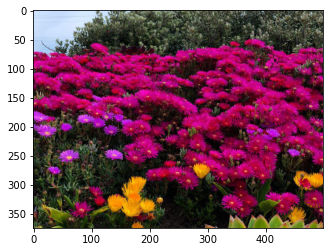

Top 3 colors: 1. dark slate gray, 2. medium violet red, 3. black
Inference time: 1.0510308742523193


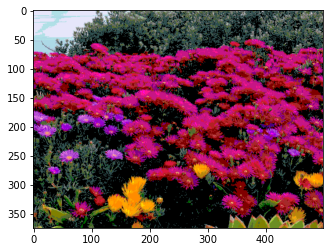

In [41]:
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time

def prep_img(filename, scale):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Downsize img
    new_shape = (int(img.shape[1]/scale), int(img.shape[0]/scale))
    resized = cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)
    
    plt.imshow(resized)
    plt.show()
    
    return resized

# Need to load color db to np arrays
colors = pd.read_csv("colors_medium.csv")
#colors = pd.read_csv("colors_small.csv")
color_array = colors[['R','G','B']].to_numpy()
color_names = colors.Name.to_numpy()

# Load and downsize image
#img = prep_img("../img/eardrops.jpg", 8)
img = prep_img("../img/flowers.jpg", 2)
#img = prep_img("../img/lego.jpg", 2)
img_shape = img.shape

t0 = time.time()

# Flatten image into (N, 3) array
pixels = img.reshape((-1, 3))

# Copy pixels into shape (N, num_colors, 3)
pixels_copy = np.repeat(pixels[:, np.newaxis, :], color_array.shape[0], axis=1)

# Get euclidean distance between each pixel and each color
dist = np.linalg.norm(pixels_copy - color_array, axis=2)

# Get index of color with smallest distance for each pixel
color_idx = np.argmin(dist, axis=1)

# Get pixel counts for each color
unique, counts = np.unique(color_idx, return_counts=True)

# Get n=3 colors with highest counts
n = 3
max_idx = np.argpartition(counts, -n)[-n:]

# Result is not sorted, sort to get order of 1st, 2nd, 3rd
max_idx = np.sort(max_idx)
top_colors = color_names[unique[max_idx]]
delta_t = time.time() - t0
print(f"Top 3 colors: 1. {top_colors[0]}, 2. {top_colors[1]}, 3. {top_colors[2]}")
print(f"Inference time: {delta_t}")

# Convert predictions back to an image and display
color_img = color_array[color_idx]
color_img = color_img.reshape(img_shape)
plt.imshow(color_img)
plt.show()
